#### [Classify Anime Characters with Fine-tuning Model](https://chainer-colab-notebook.readthedocs.io/ja/latest/notebook/hands_on_ja/chainer/classify_anime_characters.html#)
- animeface-characterデータセットを使ってIllustration2VecモデルをFine-tuningし、146種類のキャラクター顔画像を90%以上の精度で分類できるモデルを訓練する手順を追う.

chainerを使って

  - データセットオブジェクトを作る方法
  - データセットを訓練用、検証用に分割する方法
  - 訓練済み重みを持って来て、新しいタスクでFine-tuningする方法
  - データセットクラスをフルスクラッチで書く方法
  
- Google Colaboratoryの練習も同時に行う



In [1]:
# ChainerとCupyをインストール
!apt -y install libcusparse8.0 libnvrtc8.0 libnvtoolsext1
!ln -snf /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so.8.0 /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so
!pip install -q cupy-cuda80 chainer

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  libcusparse8.0 libnvrtc8.0 libnvtoolsext1
0 upgraded, 3 newly installed, 0 to remove and 0 not upgraded.
Need to get 28.9 MB of archives.
After this operation, 71.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu artful/multiverse amd64 libcusparse8.0 amd64 8.0.61-1 [22.6 MB]
Get:2 http://archive.ubuntu.com/ubuntu artful/multiverse amd64 libnvrtc8.0 amd64 8.0.61-1 [6,225 kB]
Get:3 http://archive.ubuntu.com/ubuntu artful/multiverse amd64 libnvtoolsext1 amd64 8.0.61-1 [32.2 kB]
Fetched 28.9 MB in 0s (60.6 MB/s)
Selecting previously unselected package libcusparse8.0:amd64.
(Reading database ... 18408 files and directories currently installed.)
Preparing to unpack .../libcusparse8.0_8.0.61-1_amd64.deb ...
Unpacking libcusparse8.0:amd64 (8.0.61-1) ...
Selecting previously unselected package libnvrtc8.0:amd64.
Prepari

In [2]:
# Chainer、Cupy、Numpyのバージョンの確認
import chainer
chainer.print_runtime_info()

Chainer: 4.4.0
NumPy: 1.14.5
CuPy:
  CuPy Version          : 4.4.1
  CUDA Root             : None
  CUDA Build Version    : 8000
  CUDA Driver Version   : 9000
  CUDA Runtime Version  : 8000
  cuDNN Build Version   : 7102
  cuDNN Version         : 7102
  NCCL Build Version    : 2213


In [6]:
!pip install Pillow
!pip install dill

#### データセットのダウンロード
- %%bashによって、!をつけなくてよくなる

In [8]:
%%bash
if [ ! -d animeface-character-dataset ]; then
    curl -L -O http://www.nurs.or.jp/~nagadomi/animeface-character-dataset/data/animeface-character-dataset.zip
    unzip -q animeface-character-dataset.zip
    rm -rf animeface-character-dataset.zip
fi

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  564M  100  564M    0     0  20.1M      0  0:00:28  0:00:28 --:--:-- 20.9M


#### データセットオブジェクトの作成

In [0]:
import os
import glob
from itertools import chain

IMG_DIR = 'animeface-character-dataset/thumb'

dnames = glob.glob('{}/*'.format(IMG_DIR))

fnames = [glob.glob('{}/*.png'.format(d)) for d in dnames if not os.path.exists('{}/ignore'.format(d))]

fnames = list(chain.from_iterable(fnames))
#display(fnames)

In [0]:
# それぞれにフォルダ名から一意なIDを付与
labels = [os.path.basename(os.path.dirname(fn)) for fn in fnames]
dnames = [os.path.basename(d) for d in dnames
         if not os.path.exists('{}/ignore'.format(d))]
labels = [dnames.index(l) for l in labels]

In [0]:
from chainer.datasets import LabeledImageDataset

# データセットを作成
# (img, label)のようなタプルを返すイテレータ
d = LabeledImageDataset(list(zip(fnames, labels)))

In [0]:
# データセットオブジェクトと各データへの変換を表す関数を取るラッパークラス
# data augmentationや前処理などを行う部分をデータセットクラスの外に用意できる
import numpy as np
from chainer.datasets import TransformDataset
from PIL import  Image

width, height = 160, 160

def resize(img):
  img = Image.fromarray(img.transpose(1, 2, 0))
  img = img.resize((width, height), Image.BICUBIC)
  return np.asarray(img).transpose(2, 0, 1)


def transform(inputs):
  img, label = inputs
  img = img[:3, ...]
  img = resize(img.astype(np.uint8))
  img = img - mean[:, None, None]
  img = img.astype(np.float32)
  # ランダムに左右反転
  if np.random.rand() > 0.5:
    img = img[..., ::-1]
  return img, label

# 変換付きデータセットに
#　(img, label)のようなタプルを受け取って、transform関数にくぐらせてから返すようなデータセット
td = TransformDataset(d, transform)

#### 学習と検証データセットの分割

In [0]:
# 80%を学習、20%を検証
from chainer import datasets
# split_dataset_randomを使うと、データセット内のデータを一度シャッフルしたのちに、指定した区切り目で分割したものを返す
train, valid = datasets.split_dataset_random(td, int(len(d) * 0.8), seed=0)

In [0]:
import matplotlib.pyplot as plt

if not os.path.exists('image_mean.npy'):
  t, _ = datasets.split_dataset_random(d, int(len(d)*0.8), seed=0)

  mean = np.zeros((3, height, width))
  for img, _ in t:
    img = resize(img[:3].astype(np.uint8))
    mean += img
  mean = mean/float(len(d)*0.8)
  np.save('image_mean', mean)
else:
  mean = np.load('image_mean.npy')

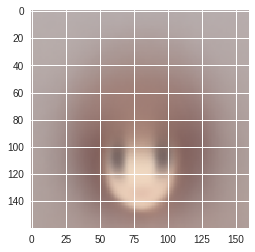

In [47]:
# 平均画像の表示
%matplotlib inline
plt.imshow(mean.transpose(1, 2, 0) / 255)
plt.show()

In [0]:
mean = mean.mean(axis=(1,2))

#### モデルの定義とFine-tuningの準備
- タグ予測や特徴抽出を行う[Illustration2Vec](https://github.com/rezoo/illustration2vec)で使われたネットワークを利用
- 最後の２層を削除してランダムに初期化された２つの全結合層を付け加えたものを新しいモデルとする

- 新しく追加した2つの全結合層だけを訓練する


In [49]:
# 配布されているillustration2Vecモデルの訓練済みパラメータをダウンロード
%%bash
if [ ! -f illust2vec_ver200.caffemodel ]; then
    curl -L -O https://github.com/rezoo/illustration2vec/releases/download/v2.0.0/illust2vec_ver200.caffemodel
fi

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   618    0   618    0     0    618      0 --:--:-- --:--:-- --:--:--  1492
100  933M  100  933M    0     0  31.1M      0  0:00:30  0:00:30 --:--:-- 35.7M


In [50]:
import dill

import chainer
import chainer.links as L
import chainer.functions as F

from chainer import Chain
from chainer.links.caffe import CaffeFunction
from chainer import serializers

class Illust2Vec(Chain):
  CAFFEMODEL_FN = 'illust2vec_ver200.caffemodel'
  
  def __init__(self, n_classes, unchain='True'):
    w = chainer.initializers.HeNormal()
    model = CaffeFunction(self.CAFFEMODEL_FN)
    del model.encode1
    del model.encode2
    del model.forwards['encode1']
    del model.forwards['encode2']
    model.layers = model.layers[:-2]
    
    super(Illust2Vec, self).__init__()
    with self.init_scope():
      self.trunk = model
      self.fc7 = L.Linear(None, 4096, initialW = w)
      self.bn7 = L.BatchNormalization(4096)
      self.fc8 = L.Linear(4096, n_classes, initialW=w)
      
  def __call__(self, x):
    h = self.trunk({'data':x}, ['conv6_3'])[0] # 元のIllust2Vecモデルのconv6_3の出力を取り出し
    h.unchain_backward()
    h = F.dropout(F.relu(self.bn7(self.fc7(h))))
    return self.fc8(h)
  
n_classes = len(dnames)
model = Illust2Vec(n_classes)
model = L.Classifier(model)
    


/usr/local/lib/python3.6/dist-packages/chainer/links/caffe/caffe_function.py:165: UserWarning: Skip the layer "encode1neuron", since CaffeFunction does notsupport Sigmoid layer
  'support %s layer' % (layer.name, layer.type))
/usr/local/lib/python3.6/dist-packages/chainer/links/caffe/caffe_function.py:165: UserWarning: Skip the layer "loss", since CaffeFunction does notsupport SigmoidCrossEntropyLoss layer
  'support %s layer' % (layer.name, layer.type))


#### 学習

- バッチサイズ: 64
- 学習率：スタート0.01、10エポック目0.1倍
- 20エポックで終了

In [0]:
from chainer import iterators
from chainer import training
from chainer import optimizers
from chainer.training import extensions
from chainer.training import triggers
from chainer.dataset import concat_examples

In [0]:
batchsize = 64
gpu_id = 0
initial_lr = 0.01
lr_drop_epoch = 10
lr_drop_ratio = 10
train_epoch = 20

In [57]:
train_iter = iterators.MultiprocessIterator(train, batchsize)
valid_iter = iterators.MultiprocessIterator(
                                            valid, batchsize, repeat=False, shuffle=False)

optimizer = optimizers.MomentumSGD(lr = initial_lr)
optimizer.setup(model)
optimizer.add_hook(chainer.optimizer.WeightDecay(0.0001))

updater = training.StandardUpdater(train_iter, optimizer, device=gpu_id)

trainer = training.Trainer(updater, (train_epoch, 'epoch'), out='AnimeFace-result')
trainer.extend(extensions.LogReport())
trainer.extend(extensions.observe_lr())


# 標準出力に書き出したい値
trainer.extend(extensions.PrintReport(
    ['epoch',
     'main/loss',
     'main/accuracy',
     'val/main/loss',
     'val/main/accuracy',
     'elapsed_time',
     'lr']))

# ロスのプロットを毎エポック自動的に保存
trainer.extend(extensions.PlotReport(
        ['main/loss',
         'val/main/loss'],
        'epoch', file_name='loss.png'))

# 精度のプロットも毎エポック自動的に保存
trainer.extend(extensions.PlotReport(
        ['main/accuracy',
         'val/main/accuracy'],
        'epoch', file_name='accuracy.png'))

# モデルのtrainプロパティをFalseに設定してvalidationするextension
trainer.extend(extensions.Evaluator(valid_iter, model, device=gpu_id), name='val')

# 指定したエポックごとに学習率をlr_drop_ratio倍にする
trainer.extend(
    extensions.ExponentialShift('lr', lr_drop_ratio),
    trigger=(lr_drop_epoch, 'epoch'))

trainer.run()

epoch       main/loss   main/accuracy  val/main/loss  val/main/accuracy  elapsed_time  lr        
1           1.52673     0.638349       0.636062       0.816691           94.6921       0.01        
2           0.534499    0.8512         0.524316       0.851116           177.56        0.01        
3           0.365319    0.892901       0.484988       0.871675           260.45        0.01        
4           0.275826    0.916908       0.487127       0.868386           343.359       0.01        
5           0.216856    0.936983       0.464744       0.875639           426.251       0.01        
6           0.193917    0.941018       0.434152       0.881955           509.335       0.01        
7           0.15908     0.953228       0.433665       0.887974           592.332       0.01        
8           0.14146     0.95892        0.453944       0.880573           675.324       0.01        
9           0.119772    0.965025       0.42952        0.886627           758.328       0.01        
10

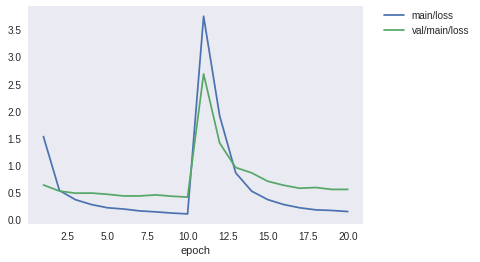

In [58]:
from IPython.display import Image
Image(filename='AnimeFace-result/loss.png')

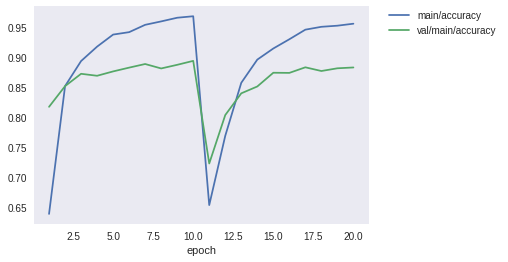

In [59]:
Image(filename='AnimeFace-result/accuracy.png')

pred: 097_kamikita_komari label: 097_kamikita_komari True


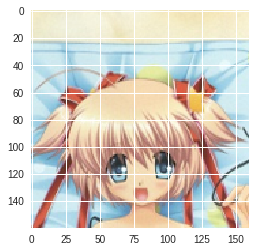

pred: 022_kururugi_suzaku label: 083_shirou_kamui False


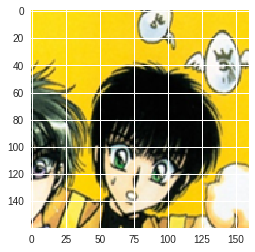

pred: 169_shihou_matsuri label: 169_shihou_matsuri True


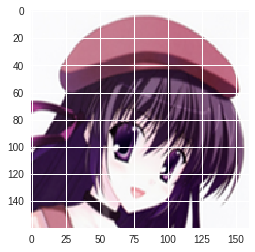

pred: 060_ichinose_kotomi label: 060_ichinose_kotomi True


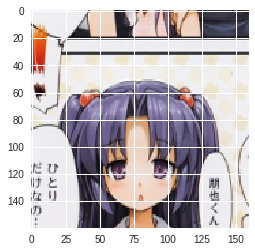

pred: 193_kagurazaka_asuna label: 193_kagurazaka_asuna True


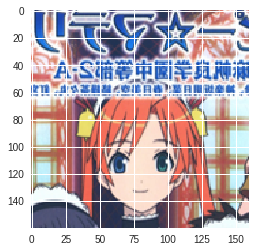

pred: 081_yuzuhara_konomi label: 081_yuzuhara_konomi True


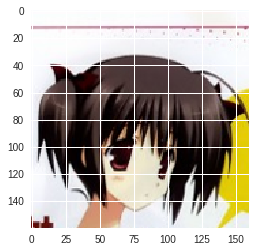

pred: 102_katagiri_yuuhi label: 102_katagiri_yuuhi True


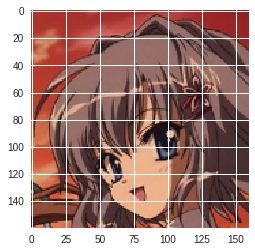

pred: 164_shindou_chihiro label: 164_shindou_chihiro True


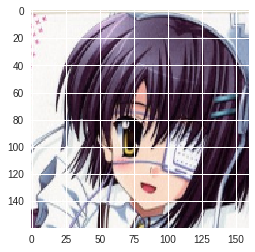

pred: 168_asagiri_mai label: 168_asagiri_mai True


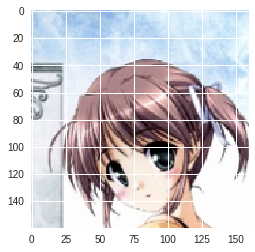

pred: 070_nijihara_ink label: 070_nijihara_ink True


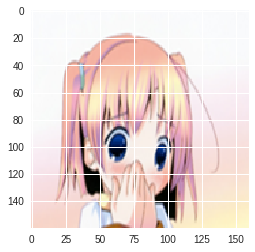

In [60]:
%matplotlib inline
import matplotlib.pyplot as plt

from PIL import Image
from chainer import cuda

chainer.config.train = False
for _ in range(10):
    x, t = valid[np.random.randint(len(valid))]
    x = cuda.to_gpu(x)
    y = F.softmax(model.predictor(x[None, ...]))
    
    pred = os.path.basename(dnames[int(y.data.argmax())])
    label = os.path.basename(dnames[t])
    
    print('pred:', pred, 'label:', label, pred == label)

    x = cuda.to_cpu(x)
    x += mean[:, None, None]
    x = x / 256
    x = np.clip(x, 0, 1)
    plt.imshow(x.transpose(1, 2, 0))
    plt.show()

In [0]:
from chainer import serializers

serializers.save_npz('animeface.model', model)

##### データの保存とか
[【秒速で無料GPUを使う】深層学習実践Tips on Colaboratory](https://qiita.com/tomo_makes/items/b3c60b10f7b25a0a5935)

[Google ColaboratoryでLINEスタンプ画像生成に挑戦！](https://qiita.com/ku_don/items/01c3abccd4b132865686)

In [63]:
from google.colab import files
files.download('animeface.model')

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 42500, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 696, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil